# Deep Learning with PyTorch : Build a Generative Adversarial Network

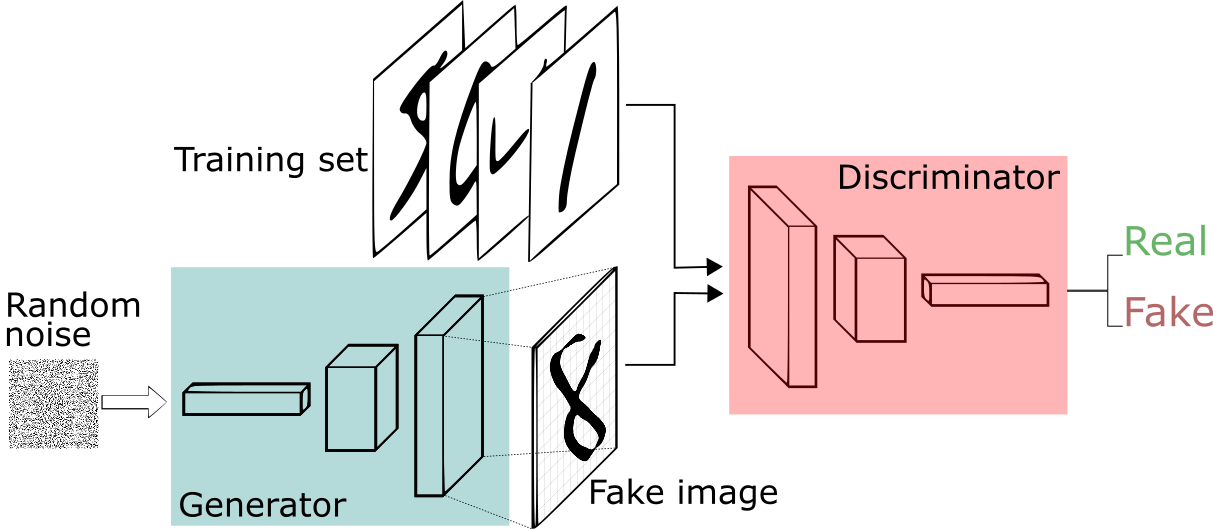

In [1]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [2]:
DEVICE = 'cuda'  # image = image.to(device)

BATCH_SIZE = 128  # trainloader, training loop

NOISE_DIM = 64   # generator model

# Optimiser Parameters

LR = 0.0002
beta_1 = 0.5
beta_2 = 0.99

# Training Variables

epochs = 30

# Load MNIST Dataset

In [3]:
from torchvision import datasets, transforms as T

In [4]:
train_augs = T.Compose([
    T.RandomRotation((-20, +20)),
    T.ToTensor()  #(h, w, c) -> (c, h, w)
])

In [5]:
trainset = datasets.MNIST('MNIST/', download = True, train = True, transform = train_augs)

100%|██████████| 9912422/9912422 [00:00<00:00, 35050440.78it/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 113956438.22it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 64617589.76it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 20053188.18it/s]


Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



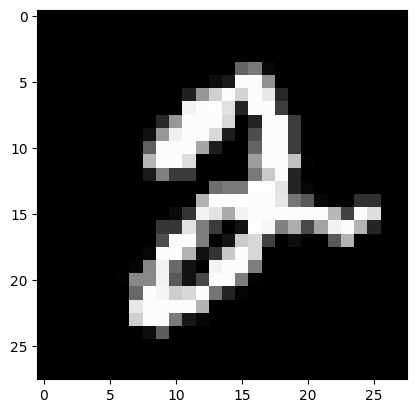

In [6]:
image, label = trainset[5]

plt.imshow(image.squeeze(), cmap = 'gray')

In [7]:
print("Total images present in trainset are:", len(trainset))

Total images present in trainset are: 60000


# Load Dataset Into Batches

In [8]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [9]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)

In [10]:
print("Total number of batches in trainloader: ", len(trainloader))

Total number of batches in trainloader:  469


In [11]:
dataiter = iter(trainloader)

images, _ = next(dataiter)  # dataiter.next() doesn't work

print(images.shape)

torch.Size([128, 1, 28, 28])


In [12]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

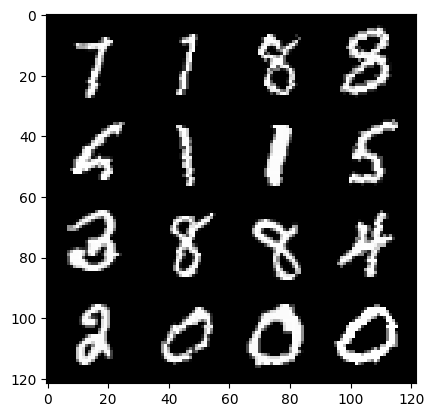

In [13]:
show_tensor_images(images, num_images = 16)

# Create Discriminator Network

In [14]:
#In case if torch summary is not installed

!pip install torchsummary

In [15]:
from torch import nn
from torchsummary import summary

In [16]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [17]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [18]:
class Discriminator(nn.Module):

  def __init__(self):

    super(Discriminator, self).__init__()

    self.block_1 = get_disc_block(1, 16, (3, 3), 2)
    self.block_2 = get_disc_block(16, 32, (5, 5), 2)
    self.block_3 = get_disc_block(32, 64, (5, 5), 2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features = 64, out_features = 1)

  def forward(self, images):

    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)

    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5


In [19]:
D = Discriminator()
D.to(DEVICE)

summary(D, input_size = (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [20]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator\n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)\n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                                 

In [21]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False):

  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh()
    )

  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [22]:
class Generator(nn.Module):

  def __init__(self, noise_dim):

    super(Generator, self).__init__()

    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(self.noise_dim, 256, (3,3), 2)
    self.block_2 = get_gen_block(256, 128, (4,4), 1)
    self.block_3 = get_gen_block(128, 64, (3,3), 2)

    self.block_4 = get_gen_block(64, 1, (4,4), 2, final_block = True)

  def forward(self, r_noise_vec):

    # (bs, noise_dim) -> (bs, noise_dim, 1, 1)
    x = r_noise_vec.view(-1, self.noise_dim,1 , 1)

    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)

    return x4

In [23]:
G = Generator(NOISE_DIM)
G.to(DEVICE)

summary(G, input_size = (1, NOISE_DIM))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [24]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [25]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [26]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

In [27]:
D_opt = torch.optim.Adam(D.parameters(), lr = LR, betas = (beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr = LR, betas = (beta_1, beta_2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1 | D_loss: 0.6773816275952468 | G_loss: 0.6674083269227034


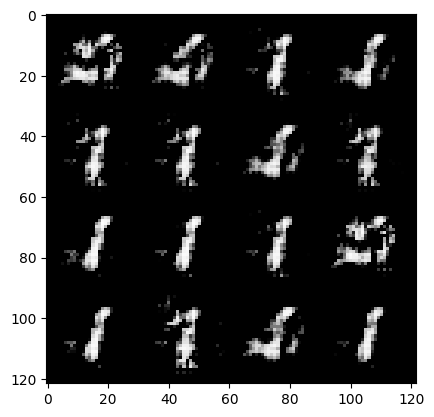

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 2 | D_loss: 0.6129150628281046 | G_loss: 0.5889474646623201


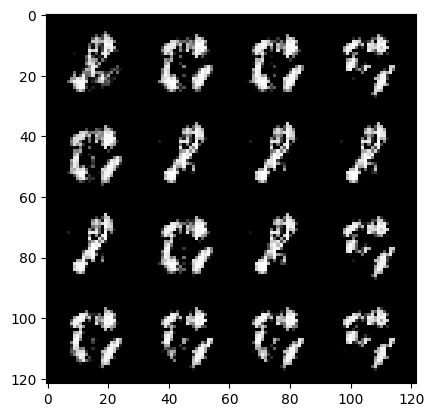

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 3 | D_loss: 0.4700317562007701 | G_loss: 0.42664168530435703


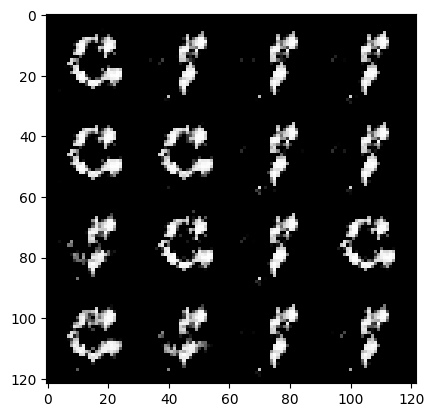

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 4 | D_loss: 0.31312056336957 | G_loss: 0.25997035932947576


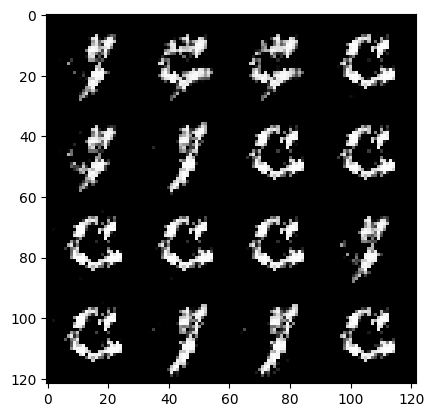

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 5 | D_loss: 0.18744727657802068 | G_loss: 0.1366304423826844


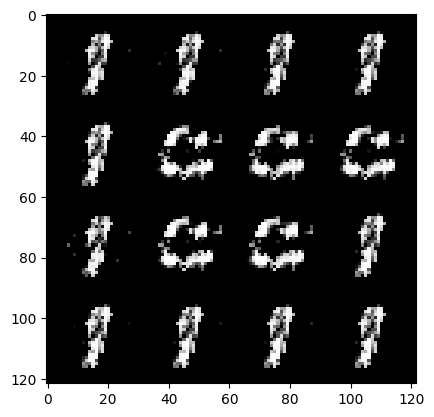

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 6 | D_loss: 0.0980270874303287 | G_loss: 0.06279858411438684


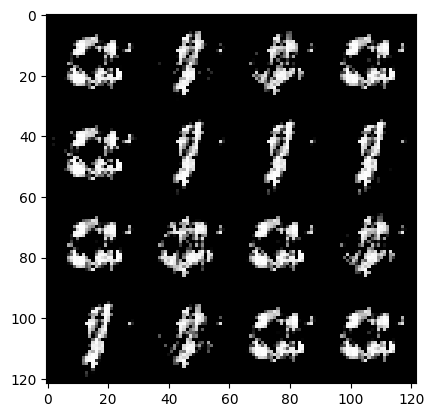

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 7 | D_loss: 0.0473092579042543 | G_loss: 0.025738935325858688


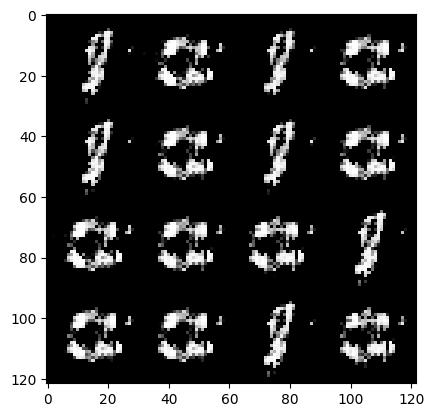

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 8 | D_loss: 0.02365194920942918 | G_loss: 0.010583349019050725


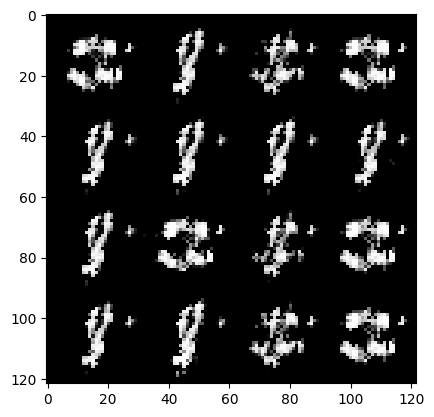

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 9 | D_loss: 0.01468183360954147 | G_loss: 0.005599709385052832


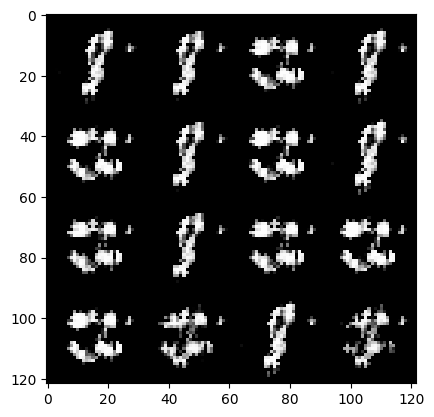

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 10 | D_loss: 0.007946295544568664 | G_loss: 0.0021489408030522183


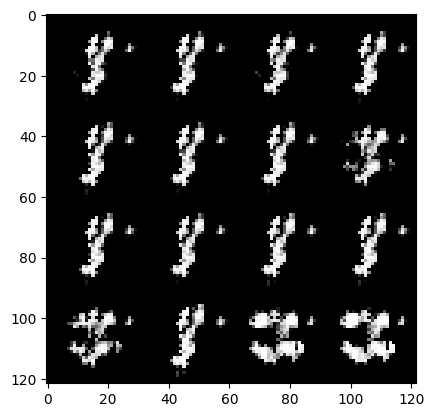

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 11 | D_loss: 0.00642949437796037 | G_loss: 0.001850691558952048


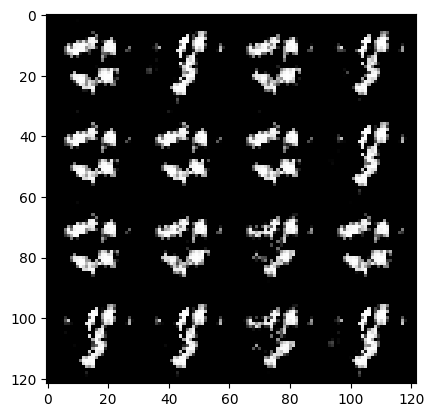

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 12 | D_loss: 0.002798215287533015 | G_loss: 0.0006079442279318026


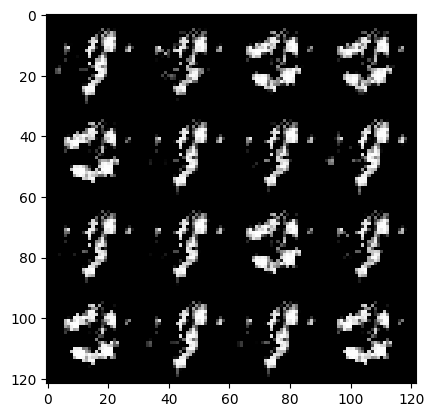

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 13 | D_loss: 0.004368130646364044 | G_loss: 0.00041460323596506247


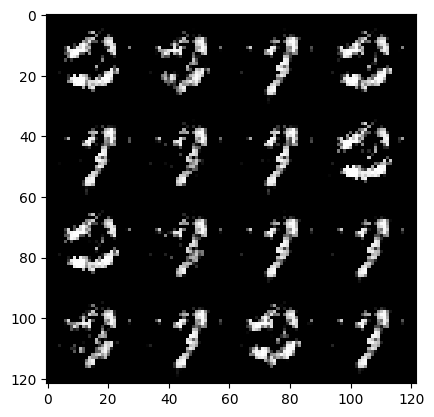

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 14 | D_loss: 0.004027521274591695 | G_loss: 0.0002770563128338789


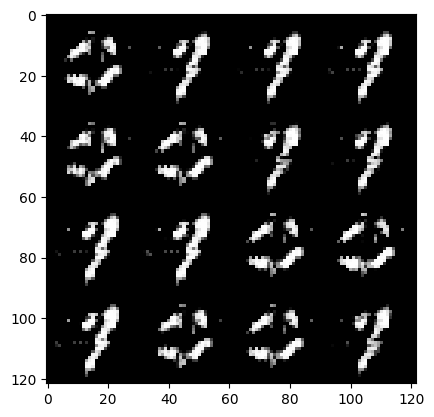

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 15 | D_loss: 0.0008556337666951977 | G_loss: 0.00011757456937428516


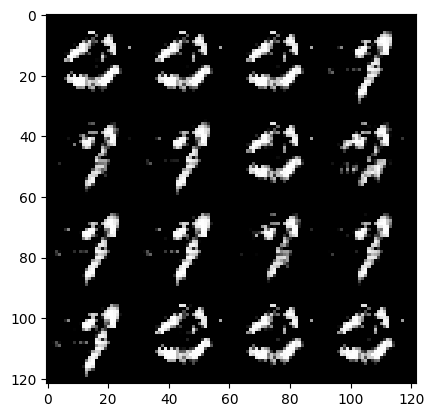

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 16 | D_loss: 0.0034958316842396892 | G_loss: 0.00019939203931634047


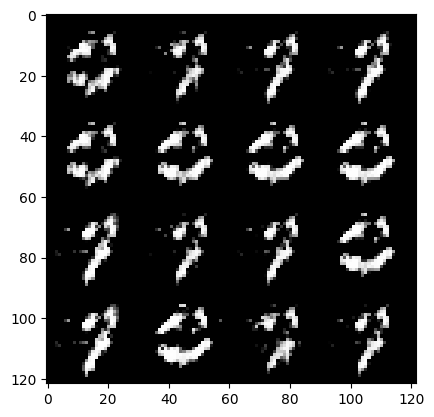

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 17 | D_loss: 0.0005052583347355672 | G_loss: 5.982618077861285e-05


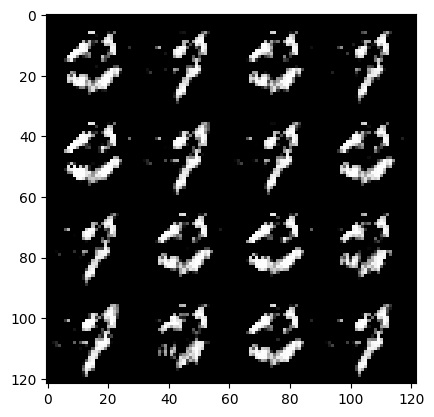

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 18 | D_loss: 0.0033755825980735727 | G_loss: 0.0002064657467372429


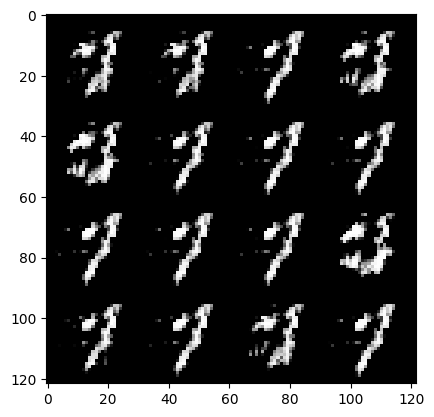

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 19 | D_loss: 0.00035050144381965125 | G_loss: 2.3828488592078152e-05


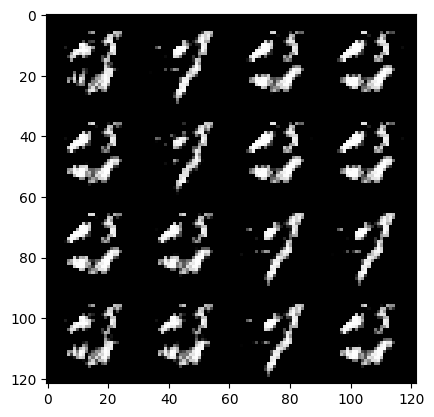

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 20 | D_loss: 0.004083420429819339 | G_loss: 9.257725236944788e-05


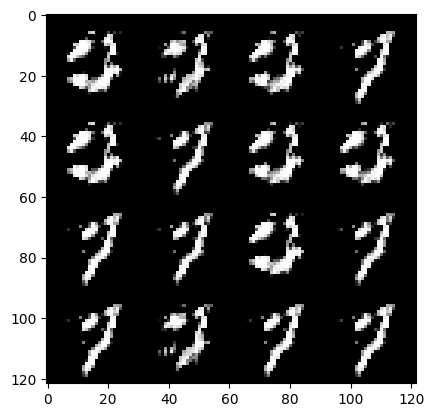

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 21 | D_loss: 0.0002605216031874727 | G_loss: 2.056343754196402e-05


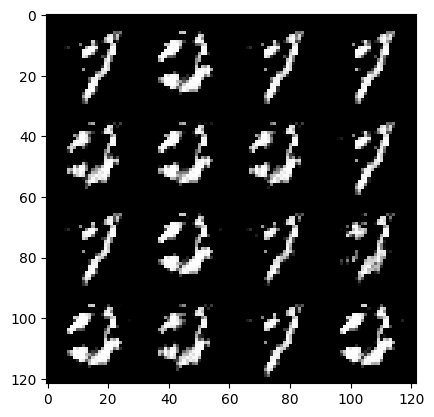

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 22 | D_loss: 0.002205223871561548 | G_loss: 2.8186124021835496e-05


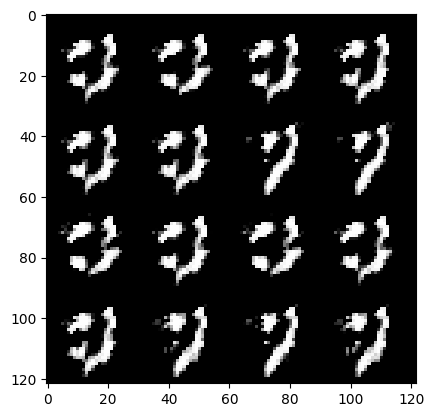

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 23 | D_loss: 0.00030096423335193193 | G_loss: 1.146681319396385e-05


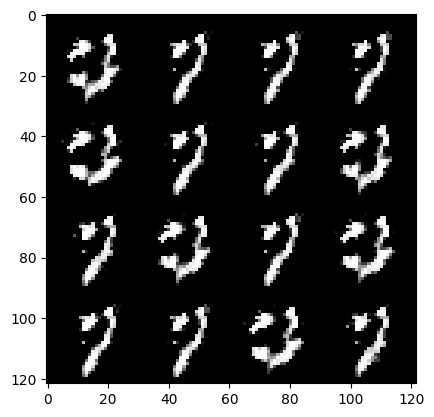

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 24 | D_loss: 0.0020286424312790084 | G_loss: 2.256997648481838e-05


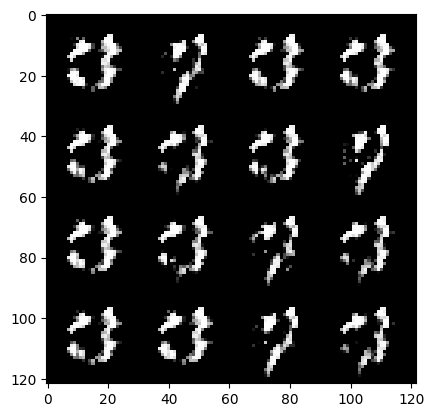

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 25 | D_loss: 0.0003243886077979347 | G_loss: 1.1970305487401284e-05


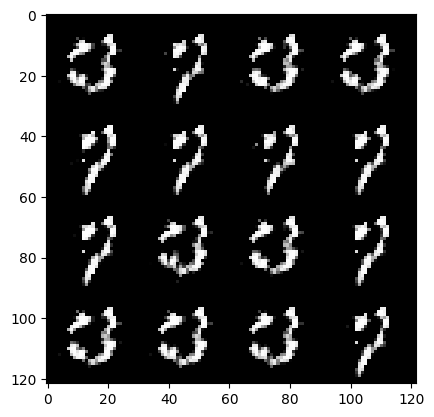

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 26 | D_loss: 9.804914049160824e-05 | G_loss: 6.648113110147641e-06


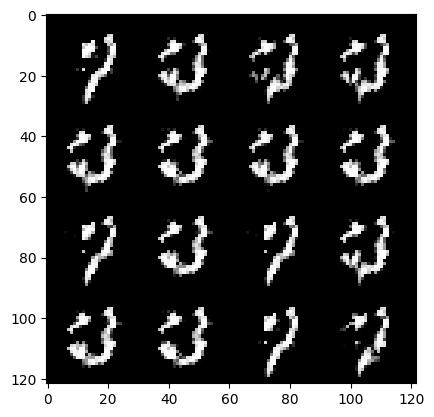

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 27 | D_loss: 0.004965131898240091 | G_loss: 0.0006038955356096922


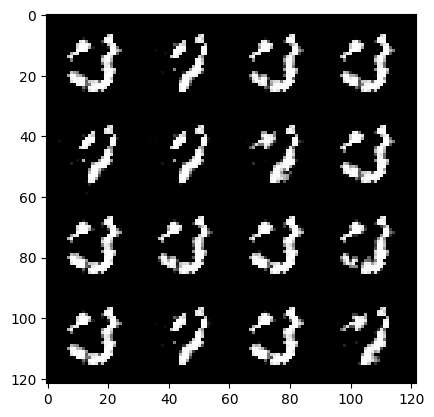

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 28 | D_loss: 0.00013066501893158476 | G_loss: 1.3153555738254212e-05


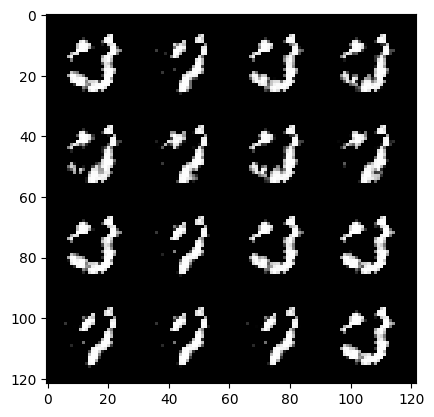

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 29 | D_loss: 0.003584449881662504 | G_loss: 0.0005588294068754947


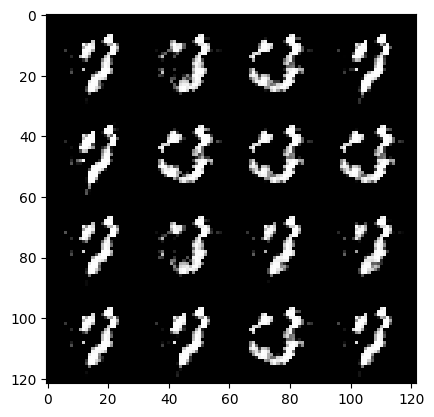

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 30 | D_loss: 0.0001407272633716046 | G_loss: 3.830365870859219e-05


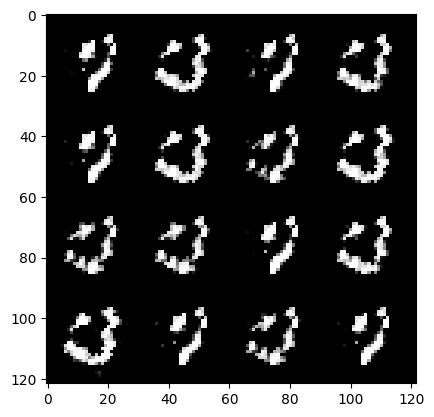

In [28]:
for i in range(epochs):

  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_img, _ in tqdm(trainloader):

    real_img = real_img.to(DEVICE)
    noise = torch.randn(BATCH_SIZE, NOISE_DIM , device = DEVICE)

    # Find loss and update weights for D

    D_opt.zero_grad()

    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss) / 2

    total_d_loss += D_loss.item()

    D_loss.backward()
    D_opt.step()

    # Find loss and update weights for G

    G_opt.zero_grad()

    noise = torch.rand(BATCH_SIZE, NOISE_DIM, device = DEVICE)

    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)

    total_g_loss += G_loss.item()

    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss / len(trainloader)
  avg_g_loss = total_g_loss / len(trainloader)

  print("Epoch: {} | D_loss: {} | G_loss: {}" . format(i+1, avg_d_loss, avg_g_loss))

  # show_tensor_images(real_img)
  show_tensor_images(fake_img)

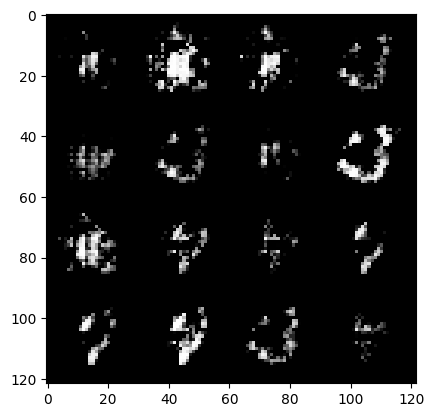

In [29]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(BATCH_SIZE, NOISE_DIM, device = DEVICE)
generated_image = G(noise)

show_tensor_images(generated_image)